In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
import sys
# !{sys.executable} -m pip install PyQt5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from quantum.Quantum import QuantumRegressor

os.environ["OMP_NUM_THREADS"] = "12"

In [2]:
# Global variables
OPTIMIZER = None
SHOTS = None
X_DIM = None
BACKEND = None
DEVICE = None
SCALE_FACTORS = None
ANSATZ = None
ENCODER = None
POSTPROCESS = None
ERROR_MITIGATION = None
LAYERS = None
TOKEN = None
HYPERPARAMETERS = None
RE_UPLOAD_DEPTH = None
MAX_ITER = None
TOLERANCE = None
NUM_QUBITS = None
BATCH_SIZE = None
NUM_CORES = None

In [3]:
def parse_settings(settings_file):
    with open(settings_file, 'r') as fp:
        settings = json.load(fp)

    global OPTIMIZER
    OPTIMIZER = settings['OPTIMIZER']

    global SHOTS
    SHOTS = settings['SHOTS']
                
    global BACKEND
    BACKEND = settings['BACKEND']

    global DEVICE
    DEVICE = settings['DEVICE']

    global SCALE_FACTORS
    SCALE_FACTORS = settings['SCALE_FACTORS']

    global POSTPROCESS
    POSTPROCESS = settings['POSTPROCESS']

    global ERROR_MITIGATION
    ERROR_MITIGATION = settings['ERROR_MITIGATION']

    global LAYERS
    LAYERS = settings['LAYERS']

    global HYPERPARAMETERS
    HYPERPARAMETERS = settings['HYPERPARAMETERS']
    # f was removed from HYPERPARAMETERS, this ensures old settings files can still run.
    if 'f' in HYPERPARAMETERS.keys():
        _ = HYPERPARAMETERS.pop('f', None)

    global RE_UPLOAD_DEPTH
    RE_UPLOAD_DEPTH = settings['RE-UPLOAD_DEPTH']

    global MAX_ITER
    MAX_ITER = settings['MAX_ITER']

    global TOLERANCE
    try:
        TOLERANCE = settings['TOLERANCE']
    except KeyError:
        TOLERANCE = None

    global NUM_QUBITS
    try:
        NUM_QUBITS = settings['NUM_QUBITS']
    except KeyError:
        NUM_QUBITS = None

    # classes aren't JSON serializable, so we store the key in the settings file and access it here.
    global ANSATZ
    ANSATZ = ANSATZ_LIST[settings['ANSATZ']]

    global ENCODER
    ENCODER = ENCODER_LIST[settings['ENCODER']]

    global BATCH_SIZE
    BATCH_SIZE = settings['BATCH_SIZE']
    
    global NUM_CORES
    NUM_CORES = settings['NUM_CORES']

In [4]:
def load_dataset(file):
    print(f'Loading dataset from {file}... ')
    data = joblib.load(file)
    X = data['X']
    y = data['y']

    global X_DIM
    _, X_DIM = X.shape
    print(f'Successfully loaded {file} into X and y data. ')
    return X, y

In [5]:
def create_kwargs():
    #  First have to apply specific ansatz settings: setting number of layers and the number of wires based on features
    ANSATZ.layers = LAYERS
    ANSATZ.set_wires(range(X_DIM))

    kwargs = {
        'encoder': ENCODER,
        'variational': ANSATZ,
        'num_qubits': X_DIM,
        'optimizer': OPTIMIZER,
        # 'optimizer': "BFGS",
        'max_iterations': MAX_ITER,
        'tol': TOLERANCE,
        'device': DEVICE,
        'shots': SHOTS,
        'backend': BACKEND,
        'postprocess': POSTPROCESS,
        'error_mitigation': ERROR_MITIGATION,
        'token': TOKEN,
        're_upload_depth': RE_UPLOAD_DEPTH,
        'batch_size': BATCH_SIZE,
        'njobs':NUM_CORES
    }
    return kwargs


In [6]:
# settings='./M-M-CZ_HWE-CNOT/M-M-CZ_HWE-CNOT.json'
settings='./A2_HWE-CNOT/A2_HWE-CNOT.json'
train_set="./PCA5_0.8_Morgan_train.bin"
test_set="./PCA5_0.8_Morgan_test.bin"
scaler="./PCA5_0.8_Morgan_scaler.bin"

In [7]:
X_train, y_train = load_dataset(train_set)
parse_settings(settings)
if DEVICE == 'qiskit.ibmq':
    save_token(instance, token)

global NUM_QUBITS
global X_DIM

if NUM_QUBITS is not None:
    X_DIM = NUM_QUBITS
elif X_DIM == 1:  # if X_DIM is None and num_qubits wasn't specified anywhere use a default value of 2.
    NUM_QUBITS = 2
    X_DIM = NUM_QUBITS

kwargs = create_kwargs()
title=False
if title is None:
    title = os.path.basename(settings)
    title, _ = os.path.splitext(title)
    
save_circuits=False
if save_circuits:
    plot_circuits(title)

if test_set is not None:
    X_test, y_test = load_dataset(test_set)
else:
    X_test, y_test = None, None

scaler = joblib.load(scaler)

Loading dataset from ./PCA5_0.8_Morgan_train.bin... 
Successfully loaded ./PCA5_0.8_Morgan_train.bin into X and y data. 
Loading dataset from ./PCA5_0.8_Morgan_test.bin... 
Successfully loaded ./PCA5_0.8_Morgan_test.bin into X and y data. 


In [8]:
dev = qml.device(DEVICE,wires=NUM_QUBITS)
@qml.qnode(dev)
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(NUM_QUBITS))
        print(features)
        variational(params, wires=range(NUM_QUBITS))

    return qml.expval(qml.PauliZ(0))

/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/__init__.py:184: PennyLaneDeprecationWarning: QubitDevice will no longer be accessible top level. Please access the class as pennylane.devices.QubitDevice
  warn(


In [12]:
encoder = ENCODER
variational= ANSATZ

LAYERS=1
re_upload_depth=3
variational.layers = LAYERS
variational.set_wires(range(NUM_QUBITS))


num_params = variational.num_params * re_upload_depth
generator = np.random.default_rng(12958234)
initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
feat = generator.uniform(-1, 1, NUM_QUBITS)

# circuit(feat,initial_parameters)

[ 0.93663967  0.88017328 -0.93767271  0.11676899 -0.20921206]
[ 0.93663967  0.88017328 -0.93767271  0.11676899 -0.20921206]
[ 0.93663967  0.88017328 -0.93767271  0.11676899 -0.20921206]


(<Figure size 3300x600 with 1 Axes>, <Axes: >)

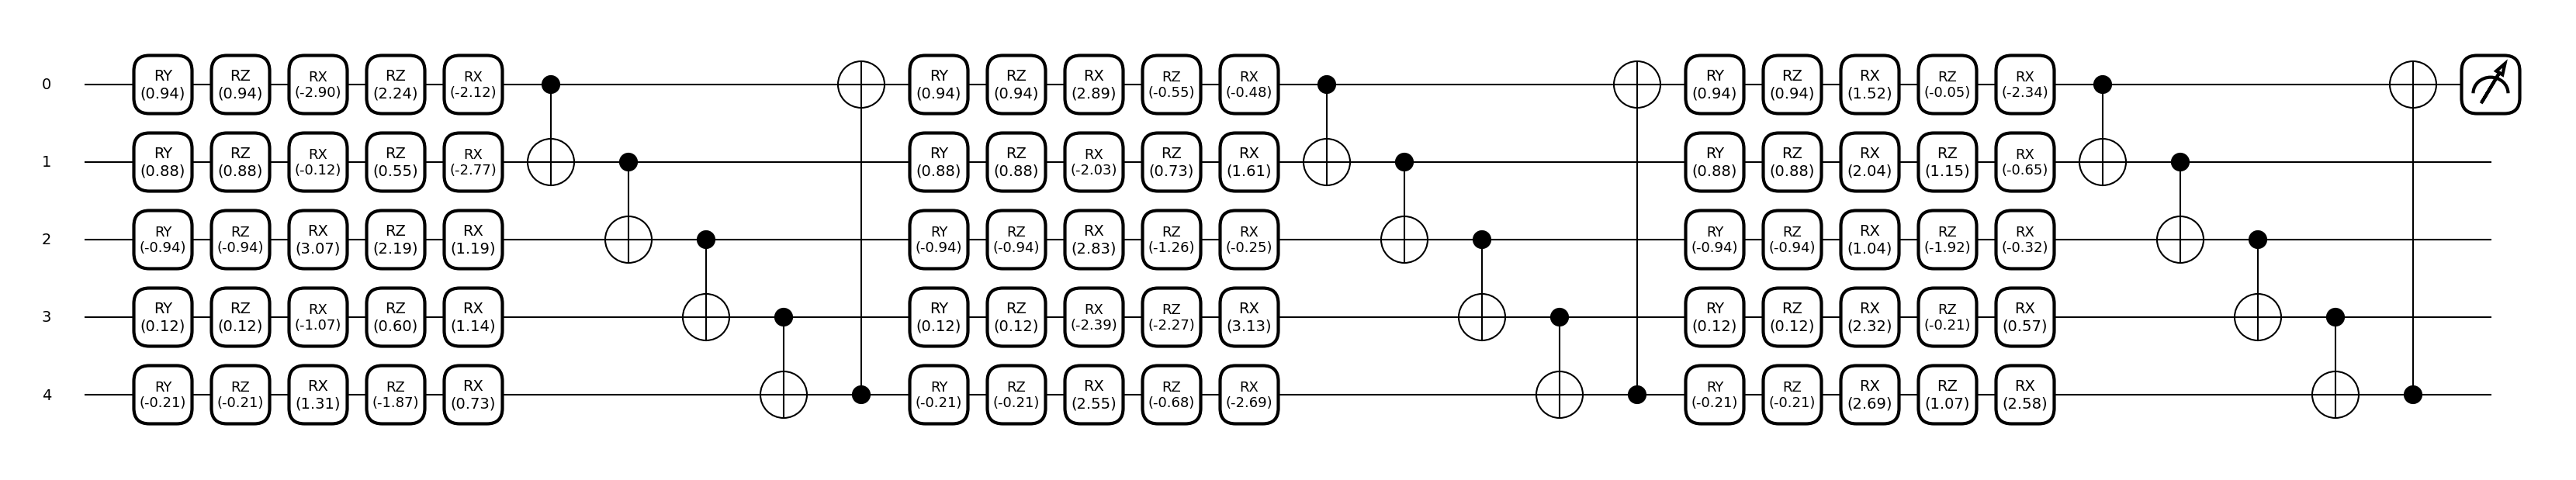

In [13]:
qml.draw_mpl(circuit,decimals=2)(feat,initial_parameters)

In [11]:

# qasmcircuit = QuantumCircuit.from_qasm_str(circuit.qtape.to_openqasm())

In [ ]:
X_train

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeQuebec

In [ ]:
def mitarai(features, num_wires):
    # encoding as proposed by Mitarai et al.
    num_features = len(features)

    for i in range(num_wires):
        feature_idx = i % num_features  # Calculate the feature index using modulo
        if np.isnan(np.arcsin(features[feature_idx])) or np.isnan(np.arccos(features[feature_idx])):
            print(f'Ignoring NaN found at index: {feature_idx}. With feature: {features[feature_idx]}. ')
        else:
            qc.ry(np.arcsin(features[feature_idx]), i)
            qc.rz(np.arccos(features[feature_idx] ** 2), i)



def entangle_cnot(num_wires):
    #  entangles all of the wires in a circular fashion using cnot gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            qc.cx(i, 0)
        else:
            qc.cx(i, i+1)


def entangle_cz(num_wires):
    #  entangles all of the wires in a circular fashion using cz gates
    for i in range(num_wires):
        
        if i == num_wires - 1:
            qc.cz(i, 0)
        else:
            qc.cz(i, i+1)


def HardwareEfficient(parameters,num_wires):
    parameters = parameters.reshape(-1,3)
    for qubit in range(num_qubits):
        qc.rx(parameters[qubit,0], qubit)  # Replace 0.5 with the actual rotation angle
        qc.rz(parameters[qubit,1], qubit)  # Replace 0.5 with the actual rotation angle
        qc.rx(parameters[qubit,2], qubit)  # Replace 0.5 with the actual rotation angle
    entangle_cnot(num_wires)

# # Layer 6: Controlled gates
# qc.cx(0, 1)
# qc.cx(1, 2)
# qc.cx(2, 3)
# qc.cx(3, 4)
# qc.cx(4, 0)    

In [ ]:
# Number of qubits
# num_qubits = 5
from qiskit.visualization import circuit_drawer
vis=False
for num_qubits in np.arange(3,16):
    
    generator = np.random.default_rng(12958234)
    angles = generator.uniform(-np.pi, np.pi, num_qubits*3).reshape(-1,3)
    
    feature = generator.uniform(-1, 1, num_qubits)
    # Create a quantum circuit
    qc = QuantumCircuit(num_qubits)
    
    mitarai(feature,num_qubits)
    entangle_cz(num_qubits)
    qc.barrier()
    mitarai(feature,num_qubits)
    entangle_cz(num_qubits)
    qc.barrier()
    HardwareEfficient(angles,num_qubits)
    qc.barrier()
    if vis==True:
        fig, ax = plt.subplots(figsize=(10,5))
        qc.draw('mpl', plot_barriers=False,ax=ax, fold=100, interactive= True)
        fig.show()

    observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
    observables = [SparsePauliOp(observables_labels)]
    print('Observables:',observables)
    qc = generate_preset_pass_manager(
        optimization_level=0).run(qc)
    
    
    estimator = StatevectorEstimator()
    
    mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
    job = estimator.run([(qc, mapped_observables)])
    
    
    qiskit_statevector_results = job.result()[0].data['evs']
    # Draw the circuit
    # print(qc)
    
    
    
    # Check pennylane statevector
    dev = qml.device(DEVICE,wires=num_qubits)
    @qml.qnode(dev)
    def circuit(features, parameters):
        #  builds the circuit with the given encoder and variational circuits.
        #  encoder and variational circuits must have only two required parameters, params/feats and wires
        for i in range(re_upload_depth):
            params = parameters.reshape(re_upload_depth,-1)[i]
            encoder(features, wires=range(num_qubits))
            variational(params, wires=range(num_qubits))
    
        return qml.expval(qml.PauliZ(0))  
        
    LAYERS=1
    re_upload_depth=1
    variational.layers = LAYERS
    variational.set_wires(range(num_qubits))
    if vis==True:
        qml.draw_mpl(circuit,decimals=3)(feature,angles)
        plt.show()
    display
    pennylane_statevector_results = circuit(feature,angles)
    print('Qiskit Statevector:',qiskit_statevector_results)
    print('Pennylane Statevector:',pennylane_statevector_results)
    print(np.isclose(qiskit_statevector_results[0],pennylane_statevector_results))
    print()

In [ ]:
num_qubits = 5
generator = np.random.default_rng(12958234)
angles = generator.uniform(-np.pi, np.pi, num_qubits*3).reshape(-1,3)

feature = generator.uniform(-1, 1, 5)
# Create a quantum circuit
qc = QuantumCircuit(num_qubits)

mitarai(feature,num_qubits)
entangle_cz(num_qubits)
qc.barrier()
mitarai(feature,num_qubits)
entangle_cz(num_qubits)
qc.barrier()
HardwareEfficient(angles,num_qubits)
qc.barrier()
if vis==True:
    fig, ax = plt.subplots(figsize=(10,5))
    qc.draw('mpl', plot_barriers=False,ax=ax, fold=100, interactive= True)
    fig.show()

observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]
print('Observables:',observables)
qc = generate_preset_pass_manager(
    optimization_level=0).run(qc)


estimator = StatevectorEstimator()

mapped_observables = [observable.apply_layout(qc.layout) for observable in observables]
job = estimator.run([(qc, mapped_observables)])


qiskit_statevector_results = job.result()[0].data['evs'] 
# Get a fake backend from the fake provider
backend = FakeQuebec()
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

qc_isa = pm.run(qc)



observables_labels = ''.join(['I']*(num_qubits-1))+"Z"
observables = [SparsePauliOp(observables_labels)]
mapped_observables = [observable.apply_layout(qc_isa.layout) for observable in observables]

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 2
estimator.options.default_shots = 5000
job = estimator.run([(qc_isa, mapped_observables)])
print(job.result()[0].data['evs'])


In [ ]:
qc.draw('mpl')

In [ ]:
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")